# **Math Score model**

## Objectives

- Train and evaluate a model for predicting a student's math score using a classification model

## Inputs

- outputs/datasets/filtered/math-score-dataset.csv
- outputs/datasets/split/math/math-test-score.csv
- outputs/datasets/split/math/math-train-score.csv
- outputs/datasets/split/math/math-test-vars.csv
- outputs/datasets/split/math/math-train-vars.csv

## Outputs

- A classification pipeline to predict a student's math score

# Change working directory

Since this notebook exists in the jupyter_notebooks directory, we need to change the current working directory from the jupyter_notebooks directory to the workspace, so that any directories created in further codes cells are added in the correct place. 

We access the current directory with the OS packages' `getcwd()` method

In [1]:
import os
current_directory = os.getcwd()
current_directory


'/workspace/Exam-Scores-Analysis/jupyter_notebooks'

We now want to set the working directory as the parent of the current working directory, jupyter_notebooks

- The `os.path.dirname()` method gets the parent directory
- The `os.chir()` method defines the new current directory
- We do this to access all of the project's files and directories, rather than those in the jupyter_notebooks directory

In [2]:
os.chdir(os.path.dirname(current_directory))
print("You set a new current directory")

You set a new current directory


To make certain of things, we now use a code cell to confirm that we have set the current working directory properly

In [3]:
current_directory = os.getcwd()
current_directory

'/workspace/Exam-Scores-Analysis'

Import packages:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### Feature  Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

### EqualFrequencyDiscretiser
from feature_engine.discretisation import EqualFrequencyDiscretiser

### packages for classification report and confusion matrix
from sklearn.metrics import make_scorer, recall_score

### Train test split
from sklearn.model_selection import train_test_split

### Packages for generating a classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Math Score pipeline

First of all, let's load the required datasets:

In [5]:
df_maths = pd.read_csv('outputs/datasets/filtered/math-score-dataset.csv')
df_maths

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,math_score
0,male,group A,high school,standard,completed,67
1,female,group D,some high school,free/reduced,none,40
2,male,group E,some college,free/reduced,none,59
3,male,group B,high school,standard,none,77
4,male,group E,associate's degree,standard,completed,78
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,73
996,male,group D,associate's degree,free/reduced,completed,85
997,female,group C,some high school,free/reduced,none,32
998,female,group C,some college,standard,none,73


## Classification task

To convert our prediction task to classification, we first need to sort the numerical math_score variable into bins. Since we are dealing with student exam scores, and the local government wants to be able to identify students at risk of scoring poorly, I think 2, 3 or 4 bins would be useful. The 3 and 4 bin approaches could be viewed similarly to the [UK Ofsted school ranking system](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/936220/Retaining_the_current_grading_system_-_arguments_and_evidence_290419.pdf), where schools are ranked as either outstanding, good, requires improvement or inadequate. Students who are predicted to fall into the bin or bins that correspond to high test scores can be marked as not requiring further intervention, whilst students predicted to fall into the bin or bins that correspond to lower test scores could be marked as requiring more attention. The 2 bin approach would be a simple binary classifier, where students are classified as either passing or failing.

Before we begin, let's define the objects that we will need to train and inspect the classification models. First, the HyperparameterOptimisationSearchClass:

In [6]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, parameters):
        self.models = models
        self.parameters = parameters
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, x, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model =  PipelineOptimization(self.models[key])

            parameters = self.parameters[key]
            grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            grid_search.fit(x, y)
            self.grid_searches[key] = grid_search

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, parameters):
            summary = {
                 'estimator': key,
                 'minimum_score': min(scores),
                 'maximum_score': max(scores),
                 'mean_score': np.mean(scores),
                 'standard_deviation_score': np.std(scores),
            }
            return pd.Series({**parameters,**summary})

        rows = []
        for k in self.grid_searches:
            parameters = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                result = self.grid_searches[k].cv_results_[key]        
                scores.append(result.reshape(len(parameters), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(parameters, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'minimum_score', 'mean_score', 'maximum_score', 'standard_deviation_score']
        columns = columns + [column for column in df.columns if column not in columns]

        return df[columns], self.grid_searches

Now the pipeline. Most pipelines use a StandardScaler step, however we don't need one here, because all of our feature variables are encoded categorical variables, and a StandardScaler only has use when we have continuous numerical variables.

In [7]:
def PipelineOptimization(model):
  pipeline_base = Pipeline([

      ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = ['gender', 'ethnicity', 'parental_education', 'lunch_program', 'test_preparation_course'] ) ),      

      ("feature_selection",  SelectFromModel(model) ),

      ("model", model ),
       
    ])

  return pipeline_base

And now the algorithms and default hyperparameters that we will use. We will use different dictionaries in each section to hold the selected model and hyperparameters that we want to test, depending on what algorithm performs best. The SGDClassifier algorithm was used, but is currently commented out due to the difficulties encountered.

In [8]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    # "SGDClassifier": SGDClassifier(random_state=0),
}

parameters_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
    # "SGDClassifier": {}
}

And finally the code for generating a classification report and confusion matrix:

In [9]:
def confusion_matrix_and_report(x, y, pipeline, label_map):

  prediction = pipeline.predict(x)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=label_map),"\n")



def clf_performance(math_train_vars, math_train_score, math_test_vars, math_test_score, pipeline, label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(math_train_vars, math_train_score, pipeline, label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(math_test_vars, math_test_score, pipeline, label_map)

## 2 Bin approach

We will now explore how well a 2 bin classifier pipeline works.

We will sort the students into bins and plot the distributions.

* The classes represent the following ranges: 
{'math_score': [-inf, 66.5, inf]} 



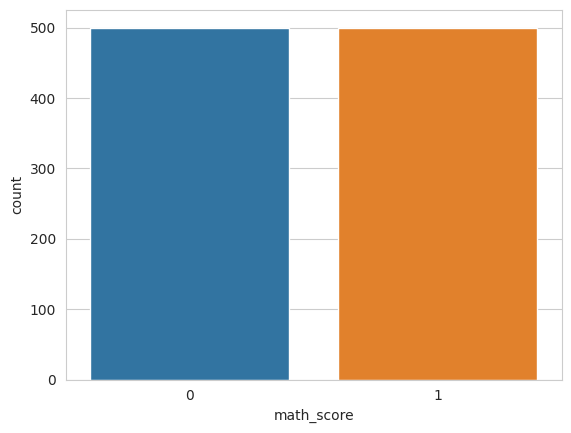

In [10]:
disc_efd_2 = EqualFrequencyDiscretiser(q=2, variables=['math_score'])
df_maths_clf_efd_2 = disc_efd_2.fit_transform(df_maths)

print(f"* The classes represent the following ranges: \n{disc_efd_2.binner_dict_} \n")
sns.countplot(data=df_maths_clf_efd_2, x='math_score')
plt.show()

The break-point for the 2 bin approach is at 66.5. Per the Pandas Profile report, the mean for the math_score variable is 66.4, so we can say that students who fall into the class 0 can predicted to score below the mean score. Ergo, identifying these students for additional support will improve their test scores and hence raise the mean score.

In [11]:
df_maths_clf_efd_2

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,math_score
0,male,group A,high school,standard,completed,1
1,female,group D,some high school,free/reduced,none,0
2,male,group E,some college,free/reduced,none,0
3,male,group B,high school,standard,none,1
4,male,group E,associate's degree,standard,completed,1
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,1
996,male,group D,associate's degree,free/reduced,completed,1
997,female,group C,some high school,free/reduced,none,0
998,female,group C,some college,standard,none,1


We must now split our dataset into train and test sets:

In [12]:
math_train_vars_2, math_test_vars_2, math_train_score_2, math_test_score_2 = train_test_split(
    df_maths_clf_efd_2.drop(['math_score'], axis=1),
    df_maths_clf_efd_2['math_score'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", math_train_vars_2.shape, math_train_score_2.shape, "\n* Test set:",  math_test_vars_2.shape, math_test_score_2.shape)

* Train set: (800, 5) (800,) 
* Test set: (200, 5) (200,)


We can now run our algorithm search, using the HyperparameterOptimisationSearch class and the models_quick_search and parameters_quick_search dictionaries:

In [13]:
model_search_2 = HyperparameterOptimizationSearch(models=models_quick_search, parameters=parameters_quick_search)
model_search_2.fit(math_train_vars_2, math_train_score_2, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Inde


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Now we can examine the results:

In [14]:
efd_2_model_grid_search_summary, efd_2_model_grid_search_pipelines = model_search_2.score_summary(sort_by='mean_score')
efd_2_model_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
1,DecisionTreeClassifier,0.519481,0.641558,0.717949,0.068196
4,ExtraTreesClassifier,0.519481,0.641558,0.717949,0.068196
2,RandomForestClassifier,0.506494,0.564302,0.602564,0.033685
5,AdaBoostClassifier,0.5,0.556743,0.641026,0.051275
0,XGBClassifier,0.415584,0.502398,0.564103,0.056027
3,GradientBoostingClassifier,0.363636,0.476623,0.641026,0.098111


Interesting - the DecisionTreeClassifier and ExtraTreeClassifier algorithms perform best. We will now see if optimising the hyperparameters improves performance: 

In [15]:
models_2 = {
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
}
 
parameters_2 = {
    "DecisionTreeClassifier":{'model__max_depth': [None, 4, 15],
                              'model__min_samples_split': [2, 50],
                              'model__min_samples_leaf': [1, 50],
                              'model__max_leaf_nodes': [None, 50],
                            },
    "ExtraTreesClassifier": {
                            'model__n_estimators': [100,50,150],
                            'model__max_depth': [None, 3, 15],
                            'model__min_samples_split': [2, 50],
                            'model__min_samples_leaf': [1,50],
                            },
}


In [16]:
parameters_search_2 = HyperparameterOptimizationSearch(models=models_2, parameters=parameters_2)
parameters_search_2.fit(math_train_vars_2, math_train_score_2, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [17]:
efd_2_parameters_grid_search_summary, efd_2_parameters_grid_search_pipelines = parameters_search_2.score_summary(sort_by='mean_score')
efd_2_parameters_grid_search_summary.head()

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,DecisionTreeClassifier,0.519481,0.641558,0.717949,0.068196,None,None,1,2,NaN
16,DecisionTreeClassifier,0.519481,0.641558,0.717949,0.068196,15,None,1,2,NaN
48,ExtraTreesClassifier,0.519481,0.641558,0.717949,0.068196,15,NaN,1,2,100
49,ExtraTreesClassifier,0.519481,0.641558,0.717949,0.068196,15,NaN,1,2,50
50,ExtraTreesClassifier,0.519481,0.641558,0.717949,0.068196,15,NaN,1,2,150


Interesting - different hyperparameter combinations have failed to improve performance. We will continue, saving the best performing model and hyperparameters, then assess feature importance and evaluate the model on the train and test sets to generate a confusion matrix and classification report. Once that is complete, we will repeat the process for the 3 and 4 bin approaches

In [18]:
maths_efd_2_best_model = efd_2_parameters_grid_search_summary.iloc[0,0]
maths_efd_2_best_model

'DecisionTreeClassifier'

In [19]:
maths_efd_2_best_parameters = efd_2_parameters_grid_search_pipelines[maths_efd_2_best_model].best_params_
maths_efd_2_best_parameters

{'model__max_depth': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2}

In [20]:
efd_2_pipeline_clf = efd_2_parameters_grid_search_pipelines[maths_efd_2_best_model].best_estimator_
efd_2_pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'ethnicity',
                                           'parental_education',
                                           'lunch_program',
                                           'test_preparation_course'])),
                ('feature_selection',
                 SelectFromModel(estimator=DecisionTreeClassifier(random_state=0))),
                ('model', DecisionTreeClassifier(random_state=0))])

Now we can assess feature importance:

* These are the 3 most important features in descending order. The model was trained on them: 
['ethnicity', 'parental_education', 'lunch_program']


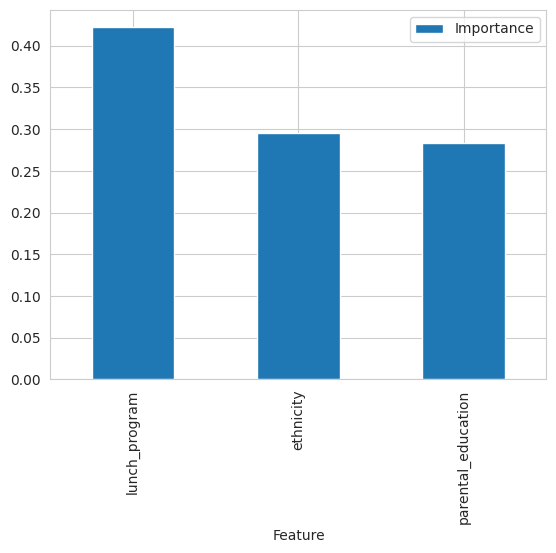

In [21]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(efd_2_pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(math_train_vars_2)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features_2 = columns_after_data_cleaning_feat_eng[efd_2_pipeline_clf['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance_2 = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[efd_2_pipeline_clf['feature_selection'].get_support()],
          'Importance': efd_2_pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

maths_efd_2_best_features = df_feature_importance_2['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_2)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_2}")

df_feature_importance_2.plot(kind='bar',x='Feature',y='Importance')
plt.show()

This is an interesting result - our prior analyses have indicated that the lunch_program, ethnicity and parental_education variables influences test scores considerably. However, we also identified the test_preparation_course variable as having influence as well, and it is interesting to note that it is absent from this plot. We can now generate a classification report and confusion matrix. When we define the label map, we can use descriptive, non-numerical labels.

In [22]:
disc_efd_2.binner_dict_['math_score']

[-inf, 66.5, inf]

In [23]:
efd_2_label_map = ['below average', 'better than average']
efd_2_label_map

['below average', 'better than average']

In [24]:
clf_performance(math_train_vars_2, math_train_score_2, math_test_vars_2, math_test_score_2, efd_2_pipeline_clf, efd_2_label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                               Actual below average Actual better than average
Prediction below average                        263                        110
Prediction better than average                  125                        302


---  Classification Report  ---
                     precision    recall  f1-score   support

      below average       0.71      0.68      0.69       388
better than average       0.71      0.73      0.72       412

           accuracy                           0.71       800
          macro avg       0.71      0.71      0.71       800
       weighted avg       0.71      0.71      0.71       800
 

#### Test Set ####

---  Confusion Matrix  ---
                               Actual below average Actual better than average
Prediction below average                         57                         37
Prediction better than average                   55                         51


---  Classification Rep

The key metrics in the classification report are the recall scores and the precision scores. Both are reasonably strong. This is a good outcome. However, it must be noted that performance on the higher-performing (or 'passing') class is considerably stronger than performance on the lower-performing (or 'failing') class. This is less ideal, since we want to be able to predict students who will perform less well, so that support can be offered. Identifying students already on track to pass their exams is, put bluntly, pointless.

## 3 Bin approach

We will now examine how well the 3 bin approach works

* The classes represent the following ranges: 
{'math_score': [-inf, 59.0, 74.0, inf]} 



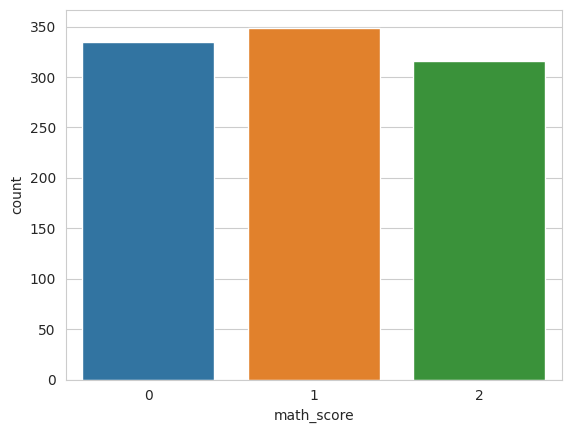

In [25]:
disc_efd_3 = EqualFrequencyDiscretiser(q=3, variables=['math_score'])
df_maths_clf_efd_3 = disc_efd_3.fit_transform(df_maths)

print(f"* The classes represent the following ranges: \n{disc_efd_3.binner_dict_} \n")
sns.countplot(data=df_maths_clf_efd_3, x='math_score')
plt.show()

Seems to be fairly evenly distributed. The bins are:
- Less than 59
- 59 - 74
- Greater than 74


We will now view the 3-bin discretised dataset:

In [26]:
df_maths_clf_efd_3

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,math_score
0,male,group A,high school,standard,completed,1
1,female,group D,some high school,free/reduced,none,0
2,male,group E,some college,free/reduced,none,0
3,male,group B,high school,standard,none,2
4,male,group E,associate's degree,standard,completed,2
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,1
996,male,group D,associate's degree,free/reduced,completed,2
997,female,group C,some high school,free/reduced,none,0
998,female,group C,some college,standard,none,1


As we have discretised the dataset, we need to split it again so that the train and test sets are discretised

In [27]:
math_train_vars_3, math_test_vars_3, math_train_score_3, math_test_score_3 = train_test_split(
    df_maths_clf_efd_3.drop(['math_score'], axis=1),
    df_maths_clf_efd_3['math_score'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", math_train_vars_3.shape, math_train_score_3.shape, "\n* Test set:",  math_test_vars_3.shape, math_test_score_3.shape)

* Train set: (800, 5) (800,) 
* Test set: (200, 5) (200,)


And now we call the previously-defined HyperparameterOptimizationSearch class

In [28]:
model_search_3 = HyperparameterOptimizationSearch(models=models_quick_search, parameters=parameters_quick_search)
model_search_3.fit(math_train_vars_3, math_train_score_3, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Inde


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [29]:
efd_3_model_grid_search_summary, efd_3_model_grid_search_pipelines = model_search_3.score_summary(sort_by='mean_score')
efd_3_model_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
1,DecisionTreeClassifier,0.538462,0.626848,0.705882,0.054035
2,RandomForestClassifier,0.519231,0.595626,0.647059,0.041906
4,ExtraTreesClassifier,0.490196,0.595475,0.705882,0.074757
0,XGBClassifier,0.470588,0.571342,0.673077,0.079215
3,GradientBoostingClassifier,0.411765,0.48997,0.576923,0.05803
5,AdaBoostClassifier,0.372549,0.447662,0.54902,0.059413


Developer's note - In addition to the standard classifier algorithms, I tried to use the SGDClassifier. This algorithm works very well, with a mean score of 0.76, far outstripping the DecisionTreeClassifier with a score of 0.62. However, the SGDClassifier has no `feature_importances_` method, so the code cell below that plots feature importances cannot be run. The SGDClassifier and its hyperparameters are included in, but commented out of, the dictionaries below, pending a solution to the stated problem.

Interesting - the SGDClassifier dramatically outperforms the other algorithms. The max_score of 1.0 is especially interesting, indicating perfect predictive power. Conventional orthodoxy would have us take only the SGDClassifier forward for hyperparameter optimisation, however in this case, the large gulf between the SGDClassifier's minimum and maximum scores is concerning, and the DecisionTreeClassifier has a much tighter (by comparison) distribution. Therefore, we will take both forward for hyperparameter optimisation.

In [30]:
models_3 = {
    "DecisionTreeClassifier":DecisionTreeClassifier(random_state=0),
    # "SGDClassifier": SGDClassifier(random_state=0)
}
 
parameters_3 = {
    "DecisionTreeClassifier":{
                            'model__max_depth': [None, 4, 15],
                            'model__min_samples_split': [2, 50],
                            'model__min_samples_leaf': [1, 50],
                            'model__max_leaf_nodes': [None, 50],
                            },
    # "SGDClassifier": {
    #                 'model__tol':[1e-3, 1e-2, 1e-4],
    #                 'model__penalty':['l2', 'l1', 'elasticnet'],
    #                 'model__alpha':[0.0001, 0.001],
    #                 },

}


In [31]:
parameters_search_3 = HyperparameterOptimizationSearch(models=models_3, parameters=parameters_3)
parameters_search_3.fit(math_train_vars_3, math_train_score_3, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [32]:
efd_3_parameters_grid_search_summary, efd_3_parameters_grid_search_pipelines = parameters_search_3.score_summary(sort_by='mean_score')
efd_3_parameters_grid_search_summary.head()

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split
0,DecisionTreeClassifier,0.538462,0.626848,0.705882,0.054035,None,None,1,2
20,DecisionTreeClassifier,0.538462,0.626848,0.705882,0.054035,15,50,1,2
16,DecisionTreeClassifier,0.538462,0.626848,0.705882,0.054035,15,None,1,2
4,DecisionTreeClassifier,0.538462,0.626848,0.705882,0.054035,None,50,1,2
8,DecisionTreeClassifier,0.333333,0.595173,0.72549,0.142349,4,None,1,2


Different hyperparameter combinations have not improved algorithm performance. We will continue, saving the best performing model and hyperparameters, then assess feature importance and evaluate the model on the train and test sets to generate a confusion matrix and classification report. Once that is complete, we will repeat the process for the dataset discretised with 4 bins.

In [33]:
maths_efd_3_best_model = efd_3_parameters_grid_search_summary.iloc[0,0]
maths_efd_3_best_model

'DecisionTreeClassifier'

In [34]:
efd_3_best_parameters = efd_3_parameters_grid_search_pipelines[maths_efd_3_best_model].best_params_
efd_3_best_parameters

{'model__max_depth': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2}

In [35]:
efd_3_pipeline_clf = efd_3_parameters_grid_search_pipelines[maths_efd_3_best_model].best_estimator_
efd_3_pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'ethnicity',
                                           'parental_education',
                                           'lunch_program',
                                           'test_preparation_course'])),
                ('feature_selection',
                 SelectFromModel(estimator=DecisionTreeClassifier(random_state=0))),
                ('model', DecisionTreeClassifier(random_state=0))])

* These are the 2 most important features in descending order. The model was trained on them: 
['ethnicity', 'parental_education']


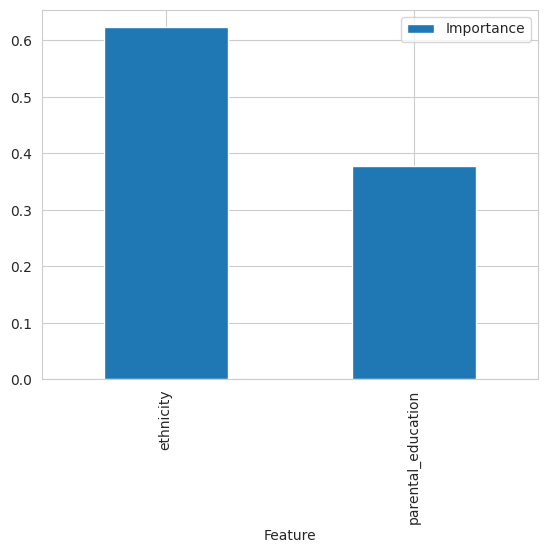

In [36]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(efd_3_pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(math_train_vars_3)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features_3 = columns_after_data_cleaning_feat_eng[efd_3_pipeline_clf['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance_3 = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[efd_3_pipeline_clf['feature_selection'].get_support()],
          'Importance': efd_3_pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

maths_efd_3_best_features = df_feature_importance_3['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_3)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_3}")

df_feature_importance_3.plot(kind='bar',x='Feature',y='Importance')
plt.show()

This is an interesting result - our analyses to until now have showed that lunch_program is an important feature variable that has significant predictive power. However, now that we have a classification task, ethnicity and parental_education have become more important.

### Confusion matrix and classification report

We'll remind ourselves of the bins:

In [37]:
disc_efd_3.binner_dict_['math_score']

[-inf, 59.0, 74.0, inf]

And create a label map to better illustrate the classification report and confusion matrix:

In [38]:
efd_3_label_map = ['<59.0', '59 to 74','>74.0']
efd_3_label_map

['<59.0', '59 to 74', '>74.0']

In [39]:
clf_performance(math_train_vars_3, math_train_score_3, math_test_vars_3, math_test_score_3, efd_3_pipeline_clf, efd_3_label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                    Actual <59.0 Actual 59 to 74 Actual >74.0
Prediction <59.0             160             105           65
Prediction 59 to 74           65             115           84
Prediction >74.0              32              62          112


---  Classification Report  ---
              precision    recall  f1-score   support

       <59.0       0.48      0.62      0.55       257
    59 to 74       0.44      0.41      0.42       282
       >74.0       0.54      0.43      0.48       261

    accuracy                           0.48       800
   macro avg       0.49      0.49      0.48       800
weighted avg       0.49      0.48      0.48       800
 

#### Test Set ####

---  Confusion Matrix  ---
                    Actual <59.0 Actual 59 to 74 Actual >74.0
Prediction <59.0              49              28           13
Prediction 59 to 74           16              21           21
Prediction >74.0              13              18     

Note from the classification report that we have a recall score of 62% on the class with a score of less than 59. However, recall performance suffers somewhat for the other 2 classes. This is, I think, acceptable. The entire point of this project is to help identify students who are likely to achieve lower test scores. Therefore, the model needs to have good performance in predicting this class. 62% is not great, but is not poor either.

## 4 Bin approach

We will now see if the 4 bin dataset has better performance. We can reuse the pipeline and dictionaries:

* The classes represent the following ranges: 
{'math_score': [-inf, 56.0, 66.5, 77.0, inf]} 



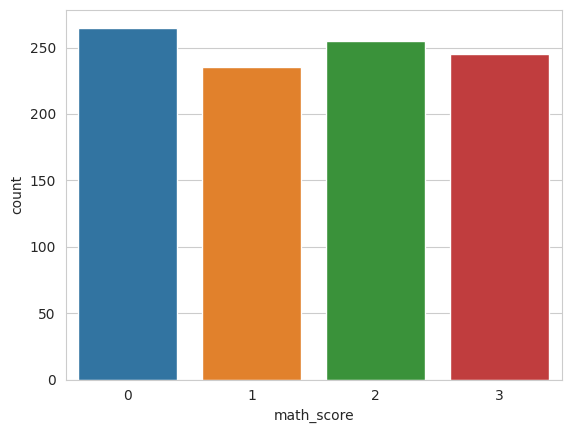

In [40]:
disc_efd_4 = EqualFrequencyDiscretiser(q=4, variables=['math_score'])
df_maths_clf_efd_4 = disc_efd_4.fit_transform(df_maths)

print(f"* The classes represent the following ranges: \n{disc_efd_4.binner_dict_} \n")
sns.countplot(data=df_maths_clf_efd_4, x='math_score')
plt.show()

In [41]:
df_maths_clf_efd_4

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,math_score
0,male,group A,high school,standard,completed,2
1,female,group D,some high school,free/reduced,none,0
2,male,group E,some college,free/reduced,none,1
3,male,group B,high school,standard,none,2
4,male,group E,associate's degree,standard,completed,3
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,2
996,male,group D,associate's degree,free/reduced,completed,3
997,female,group C,some high school,free/reduced,none,0
998,female,group C,some college,standard,none,2


We must now split the data:

In [42]:
math_train_vars_4, math_test_vars_4, math_train_score_4, math_test_score_4 = train_test_split(
    df_maths_clf_efd_4.drop(['math_score'], axis=1),
    df_maths_clf_efd_4['math_score'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", math_train_vars_4.shape, math_train_score_4.shape, "\n* Test set:",  math_test_vars_4.shape, math_test_score_4.shape)

* Train set: (800, 5) (800,) 
* Test set: (200, 5) (200,)


In [43]:
model_search_4 = HyperparameterOptimizationSearch(models=models_quick_search, parameters=parameters_quick_search)
model_search_4.fit(math_train_vars_4, math_train_score_4, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Ind


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [44]:
efd_4_model_grid_search_summary, efd_4_model_grid_search_pipelines = model_search_4.score_summary(sort_by='mean_score')
efd_4_model_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
0,XGBClassifier,0.463415,0.6,0.731707,0.106426
1,DecisionTreeClassifier,0.487805,0.580488,0.707317,0.080746
4,ExtraTreesClassifier,0.487805,0.580488,0.707317,0.080746
2,RandomForestClassifier,0.414634,0.531707,0.658537,0.096827
3,GradientBoostingClassifier,0.414634,0.487805,0.585366,0.072353
5,AdaBoostClassifier,0.292683,0.414634,0.536585,0.078656


Interesting - the 4-bin approach recommends the XGBClassifier algorithm. We shall optimise the hyperparameters:

In [45]:
models_4 = {
    "XGBClassifier":XGBClassifier(random_state=0),
}
 
parameters_4 = {
     "XGBClassifier":{'model__n_estimators': [30, 80, 200],
                    'model__max_depth': [None, 3, 15],
                    'model__learning_rate': [0.01, 0.1, 0.001],
                    'model__gamma': [0, 0.1],
                    }
  }


In [46]:
parameters_search_4 = HyperparameterOptimizationSearch(models=models_4, parameters=parameters_4)
parameters_search_4.fit(math_train_vars_4, math_train_score_4, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

In [47]:
efd_4_parameters_grid_search_summary, efd_4_parameters_grid_search_pipelines = parameters_search_4.score_summary(sort_by='mean_score')
efd_4_parameters_grid_search_summary.head()

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__gamma,model__learning_rate,model__max_depth,model__n_estimators
0,XGBClassifier,0.463415,0.6,0.731707,0.106426,0,0.01,None,30
40,XGBClassifier,0.463415,0.6,0.731707,0.106426,0.1,0.1,3,80
29,XGBClassifier,0.463415,0.6,0.731707,0.106426,0.1,0.01,None,200
30,XGBClassifier,0.463415,0.6,0.731707,0.106426,0.1,0.01,3,30
31,XGBClassifier,0.463415,0.6,0.731707,0.106426,0.1,0.01,3,80


It seems that optimising the hyperparameters has failed to improve performance. We see slightly lower performance - 0.60 vs 0.62 for the 3 bin approach.

In [48]:
maths_efd_4_best_model = efd_4_parameters_grid_search_summary.iloc[0,0]
maths_efd_4_best_model

'XGBClassifier'

In [49]:
maths_efd_4_best_parameters = efd_4_parameters_grid_search_pipelines[maths_efd_4_best_model].best_params_
maths_efd_4_best_parameters

{'model__gamma': 0,
 'model__learning_rate': 0.01,
 'model__max_depth': None,
 'model__n_estimators': 30}

In [50]:
efd_4_pipeline_clf = efd_4_parameters_grid_search_pipelines[maths_efd_4_best_model].best_estimator_
efd_4_pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'ethnicity',
                                           'parental_education',
                                           'lunch_program',
                                           'test_preparation_course'])),
                ('feature_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         gamma=N...
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
   

We can now assess feature importance

* These are the 1 most important features in descending order. The model was trained on them: 
['lunch_program']


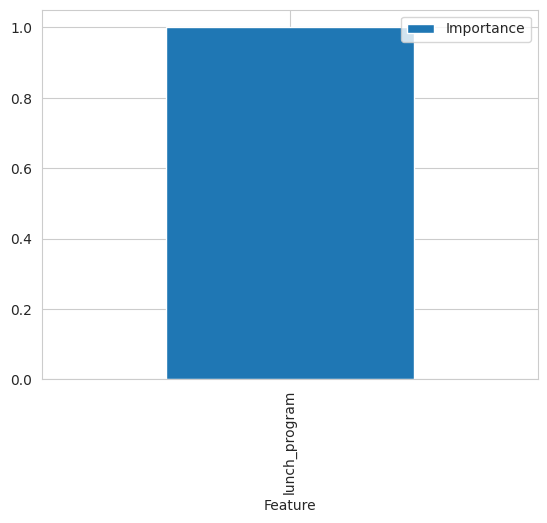

In [51]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(efd_4_pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(math_train_vars_4)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features_4 = columns_after_data_cleaning_feat_eng[efd_4_pipeline_clf['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance_4 = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[efd_4_pipeline_clf['feature_selection'].get_support()],
          'Importance': efd_4_pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

maths_efd_4_best_features = df_feature_importance_4['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_4)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_4}")

df_feature_importance_4.plot(kind='bar',x='Feature',y='Importance')
plt.show()

An interesting result - the XGBClassifier has identified lunch_program as the only important feature variable. In our previous analyses, we identified the lunch_program variable as having significant influence.

Therefore, there is a legitimate argument for selecting the 4-bin approach and the XGBClassifier, despite reduced performance.

In [52]:
disc_efd_4.binner_dict_['math_score']

[-inf, 56.0, 66.5, 77.0, inf]

In [53]:
efd_4_label_map = ['<56.0', '56 to 66.5', '66.5 to 77.0','>77.0']
efd_4_label_map

['<56.0', '56 to 66.5', '66.5 to 77.0', '>77.0']

Now we call the confusion matrix and classification report function

In [54]:
clf_performance(math_train_vars_4, math_train_score_4, math_test_vars_4, math_test_score_4, efd_4_pipeline_clf, efd_4_label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                        Actual <56.0 Actual 56 to 66.5 Actual 66.5 to 77.0  \
Prediction <56.0                 123                72                  53   
Prediction 56 to 66.5              0                 0                   0   
Prediction 66.5 to 77.0            0                 0                   0   
Prediction >77.0                  82               111                 155   

                        Actual >77.0  
Prediction <56.0                  29  
Prediction 56 to 66.5              0  
Prediction 66.5 to 77.0            0  
Prediction >77.0                 175  


---  Classification Report  ---
              precision    recall  f1-score   support

       <56.0       0.44      0.60      0.51       205
  56 to 66.5       0.00      0.00      0.00       183
66.5 to 77.0       0.00      0.00      0.00       208
       >77.0       0.33      0.86      0.48       204

    accuracy                           0.37       800
   ma

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---  Confusion Matrix  ---
                        Actual <56.0 Actual 56 to 66.5 Actual 66.5 to 77.0  \
Prediction <56.0                  35                13                  13   
Prediction 56 to 66.5              0                 0                   0   
Prediction 66.5 to 77.0            0                 0                   0   
Prediction >77.0                  25                39                  34   

                        Actual >77.0  
Prediction <56.0                  10  
Prediction 56 to 66.5              0  
Prediction 66.5 to 77.0            0  
Prediction >77.0                  31  


---  Classification Report  ---
              precision    recall  f1-score   support

       <56.0       0.49      0.58      0.53        60
  56 to 66.5       0.00      0.00      0.00        52
66.5 to 77.0       0.00      0.00      0.00        47
       >77.0       0.24      0.76      0.36        41

    accuracy                           0.33       200
   macro avg       0.18    

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This is problematic - the 4-bin approach is not able to handle scores in the middle 2 bins. This might be acceptable since we want to identify students who are likely to have low test scores, but we also want to be able to predict students who may fall into other classes, so that the local government can offer help as needed.

## Final

Therefore, we can realistically choose between the 2 and 3 bin approaches. Both have their merits. The 2 bin approach offers a simple binary classification system, and good performance with that. The 3 bin approach offers a finer-grain multiple classification system, but reduced performance on the lowest performing class, and significantly reduced performance on the other 2 classes.

The factor that decides this debate is the important features of the 2 bin and 3 bin approaches. The 2 bin approach identified the lunch_program, ethnicity and parental_education variables as the most important features, whereas the 3-bin approach used on the ethnicity and parental_education variables. We have identified the lunch_program as having significant predictive power and influence, so we must therefore proceed with the 2-bin approach.

We will redefine the pipeline - now that we have determined the most relevant features, we don't need that step.

In [55]:
maths_efd_2_best_features

['lunch_program', 'ethnicity', 'parental_education']

In [56]:
def PipelineOptimization(model):
  pipeline_final = Pipeline([

      ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = maths_efd_2_best_features ) ),

      ("model", model ),
       
    ])

  return pipeline_final

We must split the data again:

In [57]:
math_train_vars_final, math_test_vars_final, math_train_score_final, math_test_score_final = train_test_split(
    df_maths_clf_efd_2.drop(['math_score'], axis=1),
    df_maths_clf_efd_2['math_score'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", math_train_vars_final.shape, math_train_score_final.shape, "\n* Test set:",  math_test_vars_final.shape, math_test_score_final.shape)

* Train set: (800, 5) (800,) 
* Test set: (200, 5) (200,)


Now we filter the train and test sets for the ethnicity and parental_education variables, as these have been identified as the most useful

In [58]:
math_train_vars_final = math_train_vars_final.filter(maths_efd_2_best_features)
math_test_vars_final = math_test_vars_final.filter(maths_efd_2_best_features)

print("* Train set:", math_train_vars_final.shape, math_train_score_final.shape, "\n* Test set:",  math_test_vars_final.shape, math_test_score_final.shape)
math_test_vars_final.head(3)

* Train set: (800, 3) (800,) 
* Test set: (200, 3) (200,)


,lunch_program,ethnicity,parental_education
778,free/reduced,group C,master's degree
334,standard,group C,high school
271,standard,group D,some high school


Now we grab the best model and best hyperparameters

In [59]:
maths_efd_2_best_model

'DecisionTreeClassifier'

In [60]:
maths_efd_2_best_parameters

{'model__max_depth': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2}

Now we declare the best model and best parameters manually:

In [61]:
model_final = {
    "DecisionTreeClassifier":DecisionTreeClassifier(random_state=0),
}

parameters_final = {'DecisionTreeClassifier':  {
    'model__max_depth': [None],
    'model__max_leaf_nodes': [None],
    'model__min_samples_leaf': [1],
    'model__min_samples_split': [2]
    }
}
parameters_final

{'DecisionTreeClassifier': {'model__max_depth': [None],
  'model__max_leaf_nodes': [None],
  'model__min_samples_leaf': [1],
  'model__min_samples_split': [2]}}

Now GridSearchCV:

In [62]:
search_final = HyperparameterOptimizationSearch(models=model_final, parameters=parameters_final)
search_final.fit(math_train_vars_final, math_train_score_final,
           scoring = make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1,cv=5)


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [63]:
grid_search_summary_final, grid_search_pipelines_final = search_final.score_summary(sort_by='mean_score')
grid_search_summary_final

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split
0,DecisionTreeClassifier,0.519481,0.641558,0.717949,0.068196,None,None,1,2


In [64]:
final_model = grid_search_summary_final.iloc[0,0]
final_model

'DecisionTreeClassifier'

In [65]:
pipeline_clf_final = grid_search_pipelines_final[final_model].best_estimator_
pipeline_clf_final

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['lunch_program', 'ethnicity',
                                           'parental_education'])),
                ('model', DecisionTreeClassifier(random_state=0))])

Assess feature importance:

* These are the 3 most important features in descending order. The model was trained on them: 
['lunch_program', 'ethnicity', 'parental_education']


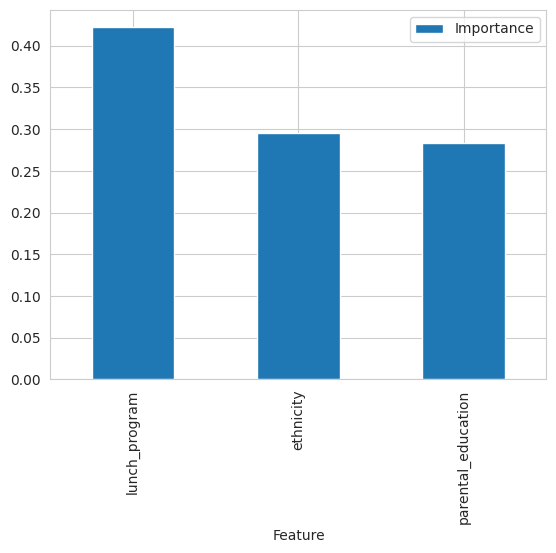

In [66]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_final.steps[:data_cleaning_feat_eng_steps])
                                        .transform(math_train_vars_final)
                                        .columns)

# create DataFrame to display feature importance
df_feature_importance_final = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng,
          'Importance': pipeline_clf_final['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

best_features_final = df_feature_importance_final['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_final)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_final}")

df_feature_importance_final.plot(kind='bar', x='Feature', y='Importance')
plt.show()

Now we generate a final confusion matrix and classification report:

In [67]:
clf_performance(math_train_vars_final, math_train_score_final, math_test_vars_final, math_test_score_final, pipeline_clf_final, efd_2_label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                               Actual below average Actual better than average
Prediction below average                        263                        110
Prediction better than average                  125                        302


---  Classification Report  ---
                     precision    recall  f1-score   support

      below average       0.71      0.68      0.69       388
better than average       0.71      0.73      0.72       412

           accuracy                           0.71       800
          macro avg       0.71      0.71      0.71       800
       weighted avg       0.71      0.71      0.71       800
 

#### Test Set ####

---  Confusion Matrix  ---
                               Actual below average Actual better than average
Prediction below average                         57                         37
Prediction better than average                   55                         51


---  Classification Rep

Excellent - performance is unchanged, proving that the variables identified as unimportant have no bearing on the predictive ability of the pipeline.

We can now save the necessary files:

- discretized and filtered train set
- discretised and filtered test set
- Modeling pipeline
- label map
- features importance plot

In [68]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_maths/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_maths/v1'


In [69]:
math_test_vars_final.head()

,lunch_program,ethnicity,parental_education
778,free/reduced,group C,master's degree
334,standard,group C,high school
271,standard,group D,some high school
802,standard,group B,some college
216,standard,group B,associate's degree


In [70]:
math_train_score_final.head()

600    0
80     0
158    1
423    1
747    1
Name: math_score, dtype: int64

In [71]:
math_test_vars_final.head()

,lunch_program,ethnicity,parental_education
778,free/reduced,group C,master's degree
334,standard,group C,high school
271,standard,group D,some high school
802,standard,group B,some college
216,standard,group B,associate's degree


In [72]:
math_test_score_final.head()

778    0
334    0
271    0
802    1
216    0
Name: math_score, dtype: int64

In [73]:
! rm outputs/ml_pipeline/predict_maths/v1/math-train-vars.csv
math_train_vars_final.to_csv(f'{file_path}/math-train-vars.csv', index=False)
print(f'math-train-vars.csv created in {file_path}')

! rm outputs/ml_pipeline/predict_maths/v1/math-train-score.csv
math_train_score_final.to_csv(f'{file_path}/math-train-score.csv', index=False)
print(f'math-train-score.csv created in {file_path}')

! rm outputs/ml_pipeline/predict_maths/v1/math-test-vars.csv
math_test_vars_final.to_csv(f'{file_path}/math-test-vars.csv', index=False)
print(f'math-test-vars.csv created in {file_path}')

! rm outputs/ml_pipeline/predict_maths/v1/math-test-score.csv
math_test_score_final.to_csv(f'{file_path}/math-test-score.csv', index=False)
print(f'math-test-score.csv created in {file_path}')

math-train-vars.csv created in outputs/ml_pipeline/predict_maths/v1
math-train-score.csv created in outputs/ml_pipeline/predict_maths/v1
math-test-vars.csv created in outputs/ml_pipeline/predict_maths/v1
math-test-score.csv created in outputs/ml_pipeline/predict_maths/v1


In [74]:
! rm outputs/ml_pipeline/predict_maths/v1/pipeline-clf-math.pkl

joblib.dump(value=pipeline_clf_final, filename=f"{file_path}/pipeline-clf-math.pkl")
print(f'pipeline-clf-math.pkl created in {file_path}')

pipeline-clf-math.pkl created in outputs/ml_pipeline/predict_maths/v1


In [75]:
! rm outputs/ml_pipeline/predict_maths/v1/label-map-math.pkl

joblib.dump(value=efd_2_label_map, filename=f"{file_path}/label-map-math.pkl")
print(f'label-map-math created in {file_path}')

label-map-math created in outputs/ml_pipeline/predict_maths/v1


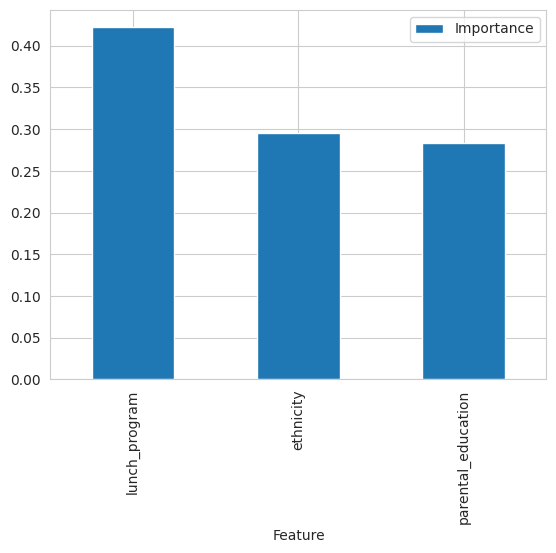

In [76]:
! rm outputs/ml_pipeline/predict_maths/v1/feature-importance-plot-maths.png

df_feature_importance_final.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/feature-importance-plot-maths.png', bbox_inches='tight')

Excellent - we have now trained a model to predict a student's math score. We needed to switch to a classification task to do this, but this has proved that we will likely require classification models for predicting the students' reading and writing score.